In [1]:
import numpy
from numpy import *
import nltk
import scipy
import pandas as pd
import re
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
#from scipy.spatial.distance import pdist
#from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import string
#stemmer = SnowballStemmer('russian')

In [2]:
df = pd.read_csv('DTranepa_итоговый опрос_курс.csv', sep=';', comment='#', engine = 'python', encoding = 'utf-8')

In [3]:
set(df['Вопрос'])

{'Ваши конструктивные предложения по улучшению курса?',
 'Какие смыслы / инициативы по цифровой трансформации Вашей школы удалось сформировать на курсе?',
 'Какие темы Вы планируете изучить подробнее после курса?',
 'Какие темы были для Вас наиболее полезны?',
 'Какие типы материалов были Вам наиболее удобны для работы?',
 'Кто из спикеров Вам понравился (можно несколько фамилий)?',
 'Насколько курс был интересен для Вас?',
 'Планируете ли Вы принять участие в следующем курсе?',
 'Порекомендуете ли Вы коллегам участие в курсе?',
 'Что в курсе Вам НЕ понравилось?',
 'Что в курсе Вам понравилось?',
 'Что из содержания курса для Вас оказалось наиболее новым / прорывным для профессиональной деятельности?',
 'Что из содержания курса для Вас оказалось совершенно неприемлемым / неприменимым и почему?'}

In [40]:
df_q = df[df['Вопрос'] ==  'Что в курсе Вам НЕ понравилось?']
df_q.drop_duplicates(['ФИО'],keep = 'last', inplace  = True)
without_answer = df_q['ответ'].isnull().sum()
df_q.dropna(subset=['ответ'], inplace=True)
df_q.reset_index(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [41]:
from rutermextract import TermExtractor
term_extractor = TermExtractor()

In [42]:
spec_chars = string.punctuation + '\n\r\xa0«»\t—…'+'1234567890'
txt =''
for x in df_q['ответ']:
    if x.isdigit():
        continue
    txt+=x+' '
txt = txt.lower()

In [43]:
from nltk import tokenize
senten = tokenize.sent_tokenize(txt)

In [44]:
sent = []
set_of_terms = set()
for x in senten:
    s = []
    terms_of_sent = []
    for term in term_extractor(x):
        s.append(term.normalized.replace(" ", "_"))
        set_of_terms.add(term.normalized.replace(" ", "_"))
    sent.append(s)

C:\ProgramData\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Обучаем Word2vec

In [45]:
from gensim.models import Word2Vec
model = Word2Vec(sent, vector_size =1000) 

In [46]:
set_of_terms = []
for x in list(model.wv.key_to_index.keys()):
    set_of_terms.append([x, model.wv.get_vector(x)])

In [47]:
words = [i[0] for i in set_of_terms]
vec = [x[1] for x in set_of_terms]


## Уменьшение размерности и визуализация


In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [49]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })
    
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)
    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [50]:
pca = PCA(n_components=2)
vec_reduced = pca.fit_transform(vec)
draw_vectors(vec_reduced[:, 0], vec_reduced[:, 1], token=words)

Figure(id='247a512a-c59c-4a54-aa93-1042e090ed41', ...)

In [51]:
tsne = TSNE(n_components=2, n_iter=500)
vec_reduced2 = tsne.fit_transform(vec)
draw_vectors(vec_reduced2[:, 0], vec_reduced2[:, 1], token=words)

Figure(id='62a0f6ca-576b-4e48-ba56-838c8c12e621', ...)

## Кластеризация

In [52]:
from sklearn.cluster import KMeans

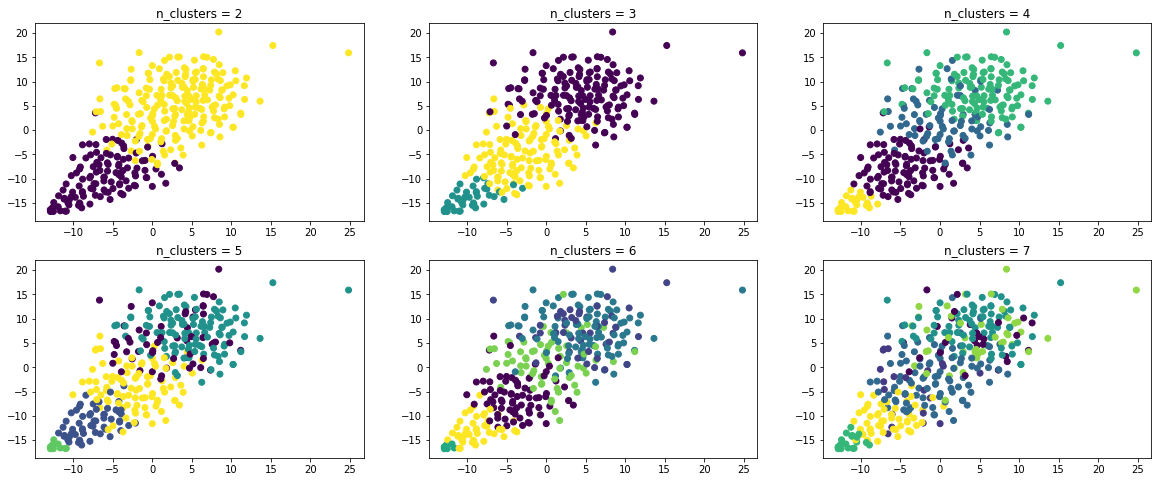

In [53]:
plt.figure(figsize= (20,8))
plt.title('Chart price', fontsize=17)

for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(vec)
    clusters = k_means.predict(vec)
    plt.subplot(2,3,n_c - 1)
    plt.scatter(vec_reduced2[:,0], vec_reduced2[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

plt.show()

In [23]:
k_means = KMeans(n_clusters = 7)
k_means = k_means.fit(vec)
clusters = k_means.predict(vec)
centr = k_means.cluster_centers_
for x in range(len(centr)):
    print(model.wv.similar_by_vector(centr[x])[:6])

[('другие_участники', 0.8029520511627197), ('эксперты', 0.7662686109542847), ('практические_задание', 0.764175295829773), ('проектные_задание', 0.7531647682189941), ('отрыв', 0.7395622134208679), ('сроки', 0.7372198700904846)]
[('лекторы', 0.8826906085014343), ('результаты', 0.8704434633255005), ('тесты', 0.8658847808837891), ('гиа', 0.8472198247909546), ('сроки_выполнения_заданий', 0.8263947367668152), ('проектные_работы', 0.819928765296936)]
[('мой_взгляд', 0.8970556855201721), ('подготовка', 0.8966650366783142), ('проектные_работа', 0.8803626894950867), ('некоторые_лекция', 0.8482983112335205), ('большое_количество', 0.8480980396270752), ('общение', 0.8384419679641724)]
[('спикеры', 0.9048773050308228), ('объём_заданий', 0.8996763825416565), ('информация', 0.8676263093948364), ('сложность', 0.8612223863601685), ('100_баллов', 0.8542529344558716), ('практические_задания', 0.8406774401664734)]
[('время', 0.9551857709884644), ('большая_объём', 0.9429975152015686), ('курс', 0.9352543354